# CSCI 4022 Final Project 
By John Danekind and Daniel Hatakeyama

## Import Stuff


In [127]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import pyminhash

# We have to implement our own version of the algorithms

# TODO: Change Kmeans implementation from scratch look at homework, online, or use claude

In [128]:
# Make subset of files since they are huge 
# Name file something different 

def make_subset(input_path, output_path):
    # Read in file 
    df = pd.read_csv(input_path)
    
    # Get a random sample of 1000 rows 
    df_sample = df.sample(n=1000, random_state=42)
    
    # Save the sample to a new file and give it a different name
    output_path = os.path.join(os.path.dirname(input_path), 'sampled_' + os.path.basename(input_path)) 
    new_file = df_sample.to_csv(output_path)
    
    return new_file

make_subset('../data/True.csv', '../data/sample_True.csv')
make_subset('../data/Fake.csv', '../data/sample_Fake.csv')



### Ideal questions to consider for now
- Can unsupervised clustering naturally separate fake from real news without using labels?
- What distinctive linguistic patterns emerge in clusters of fake vs. real news?
- Are there identifiable sub-categories within fake news that clustering can reveal?
- How do temporal patterns differ between fake and real news clusters?
- Which textual features most strongly contribute to the separation of clusters?


#### Things to think about
- Dataset is meant for more supervised learning tasks (Neural nets, svms, knn, etc)
- Maybe use KMeans, minhashing, and GMM's to cluster news into different categories
- Compare these clusters to the labels later 


#### Current plan since we have no time lmao
- Make datasets into one big dataset with no labels.
- Do K means on that data and cluster articles by similarity (could be jaccard, euclidean with vector embeddings, something else (figure out later))
- See what patterns arise from this. 
- Then take the regular data set and do a simple supervised method that is interpretable. (Logistic regression, random forest. NO BLACK BOX)
- Compare how each of the methods performed. 
- Can fake vs real news be clustered without explicit labels or is it harder to detect?

### Research Question: 
- Can document similarity patterns reveal distinctions between fake and real news? 
- If we cluster documents by some similarity measure into real and fake will this be accurate against the actual dataset? 


## Data Preparation/Preprocessing

#### Loading Data

In [129]:
# Load the data sets
fake_df = pd.read_csv('../data/sampled_Fake.csv')
real_df = pd.read_csv('../data/sampled_True.csv')

# Add labels 
fake_df['label'] = 0
real_df['label'] = 1

# Combine the data sets 
df = pd.concat([fake_df, real_df], ignore_index=True)

# Create a combined text field
df['content'] = df['title'] + ' ' + df['text']

print(f"Total articles: {len(df)}")
print(f"Fake: {len(fake_df)}, Real: {len(real_df)}")

print(f"Fake example: {df['content'].iloc[0]}")
print(f"Real example: {df[df['label'] == 1]['content'].iloc[0]}")

# Shuffle the data 
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head(10)


Total articles: 2000
Fake: 1000, Real: 1000
Fake example: ABOUT HILLARY’S COUGH: We Discovered The Secret To Why She Keeps Coughing [Video]  
Real example: Europe rights watchdog says Turkey's emergency laws go too far BRUSSELS (Reuters) - A leading European rights watchdog called on Turkey on Friday to ease post-coup state of emergency laws that have seen thousands arrested and restore power to regional authorities. President Tayyip Erdogan has overseen a mass purge in the armed forces and the judiciary, as well as a crackdown on critics including academics and journalists since a failed military coup in July last year.  An advisory body to the Council of Europe, of which Turkey is a member, acknowledged in a report  the need for certain extraordinary steps taken by Turkish authorities to face a dangerous armed conspiracy .  However...Turkish authorities have interpreted these extraordinary powers too extensively,  said the experts, known as the Venice Commission, in an opinion that h

,Unnamed: 0,title,text,subject,date,label,content
0,1052,Supreme Court dismisses Hawaii's challenge to ...,WASHINGTON (Reuters) - The U.S. Supreme Court ...,politicsNews,"October 24, 2017",1,Supreme Court dismisses Hawaii's challenge to ...
1,6120,Bernie Sanders Lets Chuck Todd Know If He’s W...,With the Democratic primary process drawing to...,News,"May 29, 2016",0,Bernie Sanders Lets Chuck Todd Know If He’s W...
2,8611,Activist Steyer expands agenda in bid to defea...,PHILADELPHIA (Reuters) - Billionaire environme...,politicsNews,"July 27, 2016",1,Activist Steyer expands agenda in bid to defea...
3,19073,SERIOUSLY? PRO-ILLEGAL ALIEN Supporters Demand...,The video begins with a clearly agitated pro-i...,left-news,"Feb 27, 2017",0,SERIOUSLY? PRO-ILLEGAL ALIEN Supporters Demand...
4,7500,Former President George W. Bush does not cast ...,"AUSTIN, Texas (Reuters) - Former Republican Pr...",politicsNews,"November 8, 2016",1,Former President George W. Bush does not cast ...
5,1768,Factbox: Trump on Twitter (Sept 13) - Tax refo...,The following statements were posted to the ve...,politicsNews,"September 13, 2017",1,Factbox: Trump on Twitter (Sept 13) - Tax refo...
6,12346,WORLD’S MOST FAMOUS VICTIMS Purchase Stunning ...,The Obamas are moving into a nine-bedroom mans...,politics,"Nov 20, 2016",0,WORLD’S MOST FAMOUS VICTIMS Purchase Stunning ...
7,12864,Man with Palestinian flag smashes Jewish resta...,AMSTERDAM (Reuters) - A man with a Palestinian...,worldnews,"December 7, 2017",1,Man with Palestinian flag smashes Jewish resta...
8,11733,INSIDE TRUMP’S CHARITY BALL Tonight At Beautif...,Trump on immigration appeal: We ll win. For t...,politics,"Feb 4, 2017",0,INSIDE TRUMP’S CHARITY BALL Tonight At Beautif...
9,8262,U.S. gives Laos extra $90 million to help clea...,VIENTIANE (Reuters) - The United States announ...,politicsNews,"September 6, 2016",1,U.S. gives Laos extra $90 million to help clea...


In [130]:
# Get all the subject rows 
df_subject = df['subject'].unique()
print(f"Subjects: {df_subject}")

df_world_news = df[df['subject'] == 'worldnews']
df_world_news.shape

Subjects: ['politicsNews' 'News' 'left-news' 'politics' 'worldnews' 'US_News'
 'Government News' 'Middle-east']


(470, 7)

#### Text Preprocessing

#### Text Processing pipeline (Look into more later )

In [131]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK data (only needs to run once)
#nltk.download('stopwords')
#nltk.download('wordnet')

# Initialize lemmatizer and stopwords
# Lemmatization is the process of converting a word to its base form 
# e.g. 'running' -> 'run'
# Stop words are common words in a language that are usually filtered out
# e.g. 'the', 'a', 'is', etc.
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
print(f"Stop words: {stop_words}")

def preprocess_text(text):
    # Convert the text to all
    text = str(text).lower()
    
    # Remove special characters, numbers, punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    
    # Tokenize
    tokens = text.split()
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    
    # Rejoin tokens
    return ' '.join(tokens)

# Apply preprocessing
df['processed_content'] = df['content'].apply(preprocess_text)
df.head()

Stop words: {"needn't", "she'd", "you'll", 'y', 'nor', "they'll", 't', 'the', 'did', 'as', 'themselves', 'you', 'am', 'all', "didn't", 'my', "that'll", 'it', 'now', 'should', 'can', 'during', "mustn't", 'needn', "we'll", 'wouldn', 'ain', "i'll", 'but', 'these', 'ours', 'll', "should've", 'not', 'which', 'until', "mightn't", 'there', 'before', 'from', 'weren', "shouldn't", 'yours', "couldn't", 'o', 'be', 'do', "we're", 'were', 'too', 'haven', 'other', 'that', 'where', 'for', 'further', 'below', 'wasn', 'your', "he'd", "she'll", 'again', "you'd", 'didn', "it'll", 'with', "aren't", 'any', 'herself', 's', 'm', 'ourselves', 'about', 'himself', 'their', "weren't", 'no', 'isn', "i'm", 'into', "i've", 'more', 'off', 'couldn', 'won', "hadn't", 'just', 'myself', 'out', 'yourself', 'was', 'ma', 'doing', 'such', "you've", "doesn't", 'he', 'very', 'why', 'are', "don't", 'aren', 'don', 'me', 'they', 'his', 'over', 'while', 'is', 'here', "they'd", 'than', 'above', 'between', 'doesn', 've', 'what', 'o

,Unnamed: 0,title,text,subject,date,label,content,processed_content
0,1052,Supreme Court dismisses Hawaii's challenge to ...,WASHINGTON (Reuters) - The U.S. Supreme Court ...,politicsNews,"October 24, 2017",1,Supreme Court dismisses Hawaii's challenge to ...,supreme court dismisses hawaii challenge trump...
1,6120,Bernie Sanders Lets Chuck Todd Know If He’s W...,With the Democratic primary process drawing to...,News,"May 29, 2016",0,Bernie Sanders Lets Chuck Todd Know If He’s W...,bernie sander let chuck todd know willing vice...
2,8611,Activist Steyer expands agenda in bid to defea...,PHILADELPHIA (Reuters) - Billionaire environme...,politicsNews,"July 27, 2016",1,Activist Steyer expands agenda in bid to defea...,activist steyer expands agenda bid defeat dang...
3,19073,SERIOUSLY? PRO-ILLEGAL ALIEN Supporters Demand...,The video begins with a clearly agitated pro-i...,left-news,"Feb 27, 2017",0,SERIOUSLY? PRO-ILLEGAL ALIEN Supporters Demand...,seriously pro illegal alien supporter demand c...
4,7500,Former President George W. Bush does not cast ...,"AUSTIN, Texas (Reuters) - Former Republican Pr...",politicsNews,"November 8, 2016",1,Former President George W. Bush does not cast ...,former president george w bush cast vote presi...


#### Implement MinHashing

In [132]:
class MinHash:
  def __init__(self, num_hashes=100, seed=42):
    """
    Initialize MinHash with specified number of hash functions  
    """
    self.num_hashes = num_hashes
    np.random.seed(seed)
    
    # Large prime number for hashing
    self.prime = 2147483647 # 32 bit prime (2^31 - 1)
    
    # Generate random parameters for hash functions (ax + b) % p 
    self.a = np.random.randint(1, self.prime, size=self.num_hashes)
    self.b = np.random.randint(0, self.prime, size=self.num_hashes)
  
  def hash_function(self, x, index):
    """
    Hash function: (ax + b) % p
    """
    return ((self.a[index] * x + self.b[index]) % self.prime)
  
  
  def shingle_text(self,text, k=9):
    """ Create shingles of size k from text"""
    # create the shingles of size k 
    shingles = set()
    for i in range(len(text) - k + 1):
      shingle = text[i:i+k]
      shingles.add(shingle)
    
    return shingles
    
  
  def compute_signiture(self, shingles):
    """
    Compute the minhash signature for a set of shingles 
    """
    # Convert shingles to integers using pythons hash functions 
    # 0x7ffffff is hex for 2147483647 (2^31 - 1)
    # This is to ensure we get a positive integer
    shingle_hashes = [hash(s) & 0x7fffffff for s in shingles]
    
    # Initialize signature array with max possible values
    signature = np.full(self.num_hashes, np.inf)
    
    # For each shinlge, update the signature 
    for shingle_hash in shingle_hashes:
      
      # For each hash function, update the signature if the hash is smaller
      for i in range(self.num_hashes):
        # Compute hash value for this shingle 
        hash_value = self.hash_function(shingle_hash, i)
        
        # Keep minimum hash value
        signature[i] = min(signature[i], hash_value)
        
    return signature.astype(np.int32)
  
  def jaccard_similarity(self, sig1, sig2):
    """
    Compute Jaccard similarity between two minhash signatures (cardinality of intersection / cardinality of union)        
    """
    # Count how many hash values match 
    matches = np.sum(sig1 == sig2)
    
    return matches / self.num_hashes

   

### Use Minhashing on data

In [133]:
# Create a MinHash object
minhash = MinHash(num_hashes=100, seed=42)

# Compute signitures for all docs in data set 
signitures = []
for i, row in df.iterrows():
    # Get shingles for this document 
    #shingles = set(row['processed_content'].split())
    shingles = minhash.shingle_text(row['processed_content'], k=5)
    
    # Compute minhash signature
    sig = minhash.compute_signiture(shingles)
    
    # Append to list
    signitures.append(sig)

signitures = np.array(signitures)

# Store signitures in the dataframe for later use 
df['signature'] = signitures.tolist()
print(f"Signitures shape: {signitures.shape}")
print(df[['signature', 'label']].head(10))

Signitures shape: (2000, 100)
                                           signature  label
0  [1161185, 1807078, 763898, 3990675, 6503685, 5...      1
1  [1936383, 1640004, 763898, 713749, 1679077, 32...      0
2  [196853, 1965095, 737982, 1476687, 2396342, 52...      1
3  [2837401, 1352727, 412, 1983431, 676013, 66920...      0
4  [2674198, 13603755, 2849728, 13739636, 3118448...      1
5  [616688, 2165723, 4214094, 2379151, 10638695, ...      1
6  [149204, 981195, 3376918, 5557366, 3543556, 65...      0
7  [4862695, 223267, 5045076, 13114471, 5614571, ...      1
8  [3889943, 4092448, 412, 6005203, 562299, 10457...      0
9  [2071738, 1497869, 118471, 528170, 112050, 762...      1


### Compute Similarity Matrix

In [134]:
def compute_similarity_matrix(signitures):
  """Compute pairwise similairity for all documents"""
  
  n = len(signitures)
  similarity_matrix = np.zeros((n,n))
  
  for i in range(n): 
    # A document is always 100% similar to itself
    similarity_matrix[i,i] = float(1.0)
    
    for j in range(i+1, n):
      similarity = np.sum(signitures[i] == signitures[j]) / len(signitures[i])
      similarity_matrix[i,j] = similarity
      similarity_matrix[j,i] = similarity
      
    if i % 100 == 0 and i > 0:
      print(f"Processed {i}/{n} documents")
  
  return similarity_matrix

similarity_matrix = compute_similarity_matrix(signitures)
print(f"Similarity matrix:{similarity_matrix}" )

Processed 100/2000 documents
Processed 200/2000 documents
Processed 300/2000 documents
Processed 400/2000 documents
Processed 500/2000 documents
Processed 600/2000 documents
Processed 700/2000 documents
Processed 800/2000 documents
Processed 900/2000 documents
Processed 1000/2000 documents
Processed 1100/2000 documents
Processed 1200/2000 documents
Processed 1300/2000 documents
Processed 1400/2000 documents
Processed 1500/2000 documents
Processed 1600/2000 documents
Processed 1700/2000 documents
Processed 1800/2000 documents
Processed 1900/2000 documents
Similarity matrix:[[1.   0.03 0.08 ... 0.01 0.05 0.02]
 [0.03 1.   0.1  ... 0.09 0.05 0.01]
 [0.08 0.1  1.   ... 0.08 0.06 0.03]
 ...
 [0.01 0.09 0.08 ... 1.   0.06 0.04]
 [0.05 0.05 0.06 ... 0.06 1.   0.01]
 [0.02 0.01 0.03 ... 0.04 0.01 1.  ]]


## Cluster with K-Means

Distance matrix shape: (2000, 2000)
Cluster distribution:

         Fake News  Real News
Cluster                      
0              609        627
1              391        373

Cluster interpretations:
Cluster 0: Real News
Cluster 1: Fake News
Clustering accuracy: 0.5090


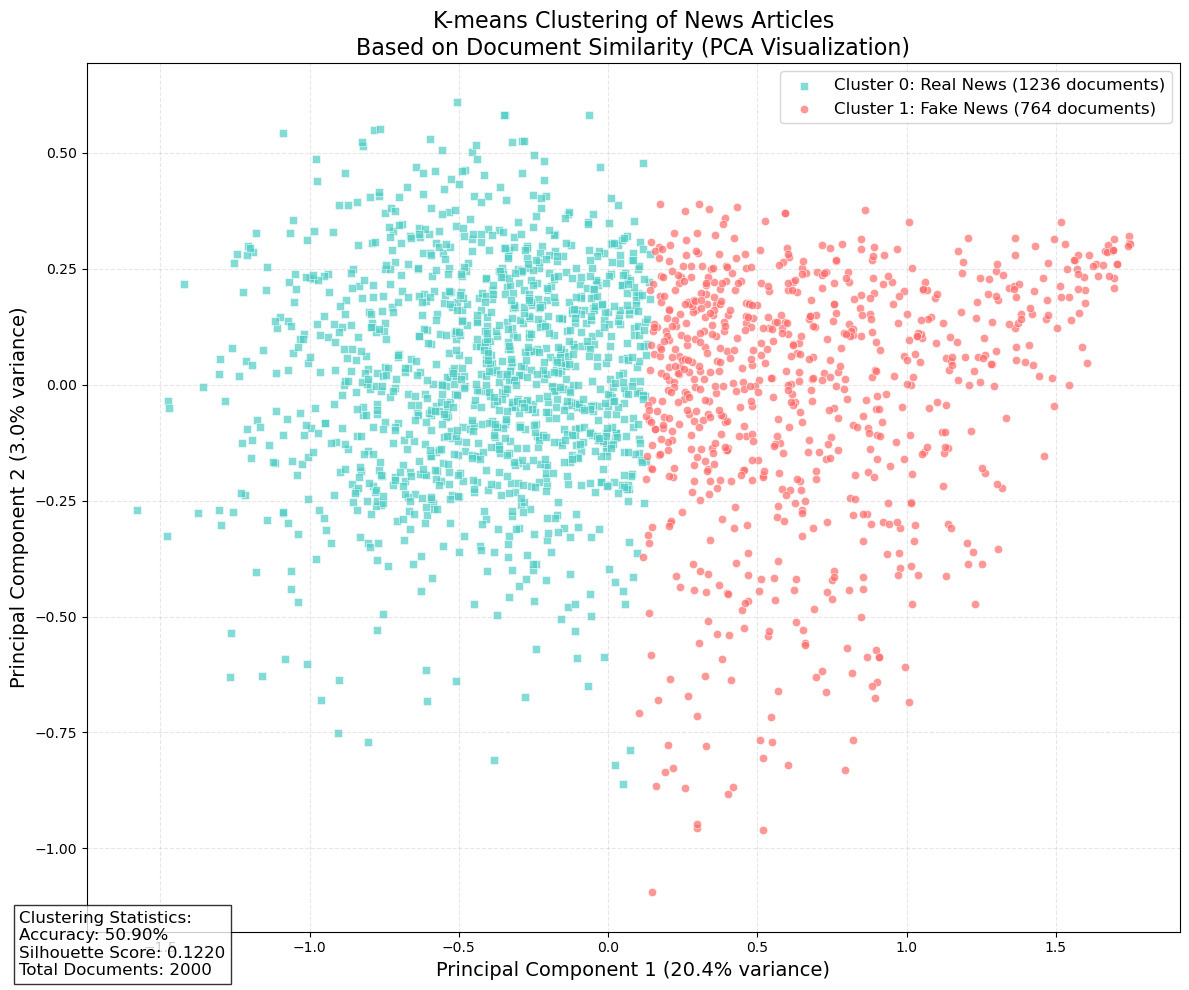

Silhouette Score: 0.1220


In [135]:
# K Means clustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Convert similarity matrix to distance matrix
distance_matrix = 1 - similarity_matrix
print(f"Distance matrix shape: {distance_matrix.shape}")

# Apply KMeans clustering
k = 2
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
cluster_labels = kmeans.fit_predict(distance_matrix)

# Add cluster labels to the dataframe
df['cluster'] = cluster_labels

# Create comparison dataframe
comparisons_df = pd.DataFrame({
    'cluster': df['cluster'],
    'actual_label': df['label']
})

# Count documents in each cluster by actual label
cluster_comparison = pd.crosstab(
    comparisons_df['cluster'],
    comparisons_df['actual_label'],
    rownames=['Cluster'],
    colnames=['Actual Label'],
)

# Rename columns for clarity
cluster_comparison.columns = ['Fake News', 'Real News']
print("Cluster distribution:\n")
print(cluster_comparison)

# Determine which cluster corresponds to which label
# Assign cluster to "Fake" or "Real" based on majority in each cluster
cluster_assignments = {}
for i in range(k):
    if cluster_comparison.loc[i, 'Fake News'] > cluster_comparison.loc[i, 'Real News']:
        cluster_assignments[i] = 'Fake News'
    else:
        cluster_assignments[i] = 'Real News'

print("\nCluster interpretations:")
for cluster, label in cluster_assignments.items():
    print(f"Cluster {cluster}: {label}")

# Calculate accuracy
total_docs = len(df)
# Count correctly assigned documents (based on majority class in each cluster)
correct_assignments = 0
for i in range(k):
    if cluster_assignments[i] == 'Fake News':
        correct_assignments += cluster_comparison.loc[i, 'Fake News']
    else:
        correct_assignments += cluster_comparison.loc[i, 'Real News']

accuracy = correct_assignments / total_docs
print(f"Clustering accuracy: {accuracy:.4f}")

# Visualization with PCA for dimensionality reduction instead of MDS
# PCA requires a dense matrix, so convert if needed
if isinstance(distance_matrix, np.ndarray):
    dense_matrix = distance_matrix
else:
    dense_matrix = distance_matrix.toarray()

# Apply PCA for visualization (2 components)
pca = PCA(n_components=2, random_state=42)
pos = pca.fit_transform(dense_matrix)

# Plot with clear labels
plt.figure(figsize=(12, 10))

# Define colors and markers
colors = ['#FF6B6B', '#4ECDC4']  # Red for fake, teal for real
markers = ['o', 's']  # Circle for fake, square for real

# Plot each cluster with meaningful labels
for i in range(k):
    cluster_points = pos[cluster_labels == i]
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        color=colors[0] if cluster_assignments[i] == 'Fake News' else colors[1],
        marker=markers[0] if cluster_assignments[i] == 'Fake News' else markers[1],
        label=f'Cluster {i}: {cluster_assignments[i]} ({len(cluster_points)} documents)',
        alpha=0.7,
        edgecolor='w',
        linewidth=0.5
    )

# Add title and labels
plt.title('K-means Clustering of News Articles\nBased on Document Similarity (PCA Visualization)', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=14)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.grid(True, linestyle='--', alpha=0.3)

# Add stats in textbox
stats_text = f"Clustering Statistics:\n"
stats_text += f"Accuracy: {accuracy:.2%}\n"
stats_text += f"Silhouette Score: {silhouette_score(distance_matrix, cluster_labels):.4f}\n"
stats_text += f"Total Documents: {total_docs}"
plt.figtext(0.02, 0.02, stats_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print silhouette score
silhouette_avg = silhouette_score(distance_matrix, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

## Interpretation of Plots and Resutls Above
Our initial idea was to use MinHashing and document similarity as a precrusor to KMeans clustering. We take the distances of the similarity measures and use that for KMeans. We use a value of K = 2 and the two clusters represent real and fake news. With an accuracy score of around 50%, this leads me to believe that we need to further investigate and cluster for each news category as well. For each category of news, there is likley a decent mix of both real and fake. In addition, using just raw, shingled words does not provide us with much value. This apporach only tells us the similarity between given documents and doesn't take into account any of the semantic meaning or context. So, moving forward, we will try a different distance method and try KMeans again and see what the results are. In addition, we want to explore the clustering results from each category.The Silhouette score is a metric used to evaluate how good clustering results are in data clustering. This score is calculated by measuring each data point’s similarity to the cluster it belongs to and how different it is from other clusters. The score ranges from -1 to 1 and where -1 would represent being in the wrong cluster, a score near 0 represents the correct cluster but right on the decision boundry, and a score near 1 represents good clustering. It's formula is: $\frac{(b_{i} - a_{i})}{max(a_{i}, b_{i})} $. We have Silhouette score of around 0.1 which leads us to believe that simply trying to cluster all the news articles as real or fake without taking into account the category is not going to provide much insight. 

# TODO: If you have time do jaccard and see the accuracy of each category

#### Overall Cluster Comparison with Ground Truth Values 


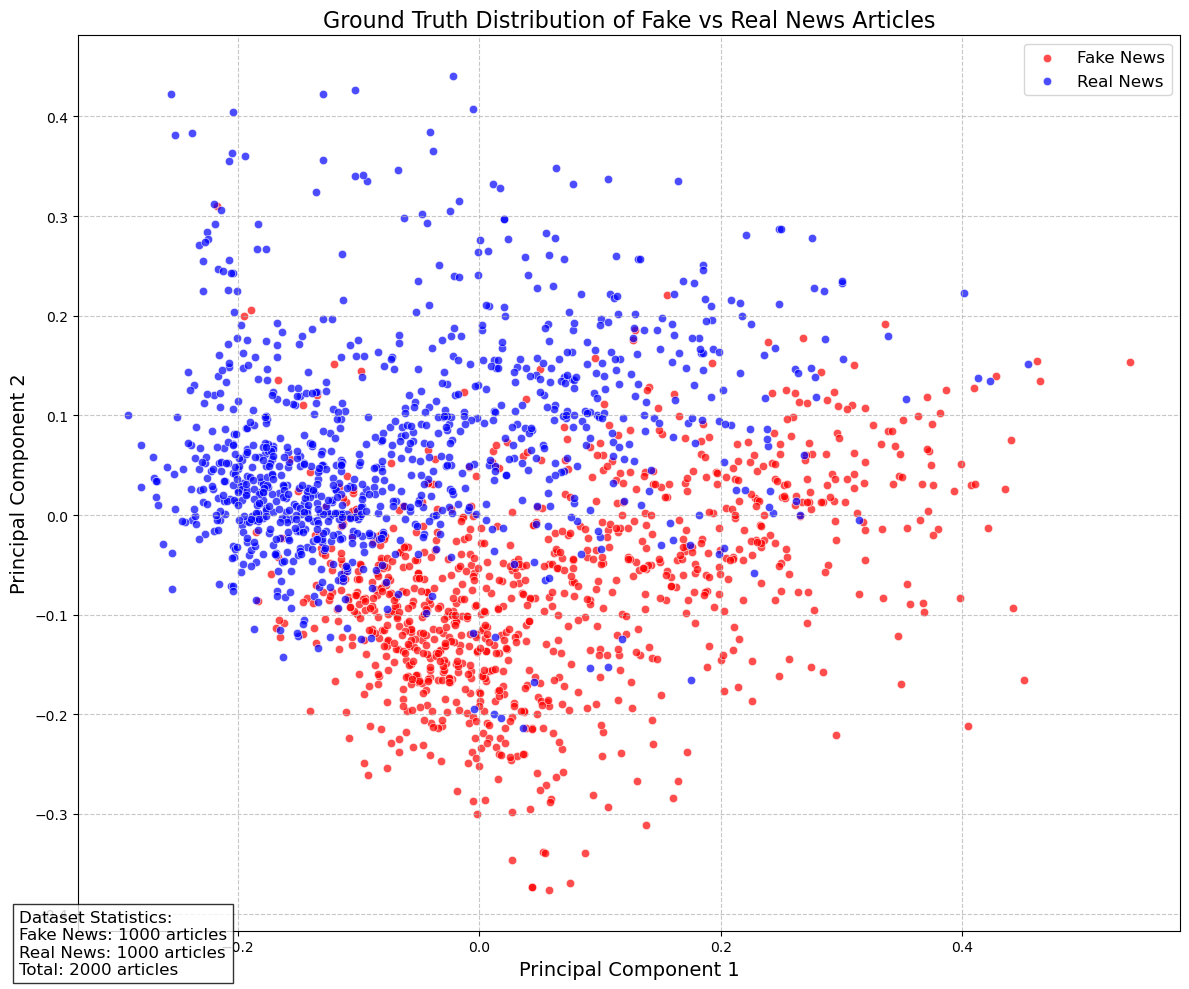

In [136]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Step 1: Convert text to numerical features using TF-IDF
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X = tfidf.fit_transform(df['content'])

# Step 2: Use PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Step 3: Create the ground truth visualization
plt.figure(figsize=(12, 10))
colors = {0: 'red', 1: 'blue'}
labels = {0: 'Fake News', 1: 'Real News'}

# Plot each point with color based on the actual label
for label_value in [0, 1]:
    mask = df['label'] == label_value
    plt.scatter(
        X_pca[mask, 0], 
        X_pca[mask, 1],
        c=colors[label_value],
        label=labels[label_value],
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )

# Add title and labels
plt.title('Ground Truth Distribution of Fake vs Real News Articles', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add some statistics text box
fake_count = sum(df['label'] == 0)
real_count = sum(df['label'] == 1)
stats_text = f"Dataset Statistics:\nFake News: {fake_count} articles\nReal News: {real_count} articles\nTotal: {len(df)} articles"
plt.figtext(0.02, 0.02, stats_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

#### Discussion
We plotted the actual labels as clusters above. Seeing how the data is split 50/50 and there is some noticalble overlap in the data, this leads us to believe that once again not taking into account different categories of news as well as the words within the news themselves, we cannot conclude much

### Use TF-IDF Vectors Instead of Minhashing with Jaccard with KMeans 

* $TF(t,d) = \frac{\text{Number of times term t appears in document d}}{\text{Total number of terms in document d}}$

* $IDF(t,D) = \log(\frac{\text{Total number of documents in corpus D}}{Number of documents containing term t})$


TF-IDF stands for term frequency-inverse document frequency. It is a statistical measure that evaluates the importance of a word in a document relative to a collection of documents. Unlike simple word frequency, TF-IDF balances common and rare words to highlight the most meaningful terms. Term frequency measures how often a word appears in a document and a higher frequency signifies greater importance. Frequency inverse document reduces the weight of of rare words. When combining these together, we get a TF-IDF score for each word. We then take the score of each word from a document and put it into a vector. We will do this for every word in every document and this is what will serve as input to our KMeans model. 

##### For the entire dataset

In [137]:
# Import accuracy_score, confusion_matrix, and silhouette_score for to test for accuracy 
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score

# Use the entire dataset (not grouped by subject)
print(f"\nAnalyzing entire dataset with {len(df)} articles")

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=1000, # number of features (words) to keep
                       ngram_range=(1, 2), # Number of words to consider (1-2)
                       stop_words='english') # Stop words are common words that we will filter out

# Fit and transform the data 
X = tfidf.fit_transform(df['processed_content'])

# Apply K-means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Add cluster labels
df_all = df.copy()
df_all['cluster'] = clusters

# Determine cluster mapping (which cluster corresponds to fake/real)
# Count fake news in each cluster
fake_in_cluster0 = sum((df_all['cluster'] == 0) & (df_all['label'] == 0))
fake_in_cluster1 = sum((df_all['cluster'] == 1) & (df_all['label'] == 0))

# Assign fake news label to cluster with more fake news
if fake_in_cluster0 > fake_in_cluster1:
    # Cluster 0 = Fake, Cluster 1 = Real
    predicted_labels = df_all['cluster'].copy()
else:
    # Cluster 1 = Fake, Cluster 0 = Real
    # Need to flip the labels (0->1, 1->0)
    predicted_labels = 1 - df_all['cluster']

# Calculate accuracy
accuracy = accuracy_score(df_all['label'], predicted_labels)

# Calculate silhouette score
sil_score = silhouette_score(X, clusters)

# Get feature names and top features for each cluster
feature_names = tfidf.get_feature_names_out()
centers = kmeans.cluster_centers_

# Determine which cluster represents fake news
fake_cluster = 0 if fake_in_cluster0 > fake_in_cluster1 else 1
real_cluster = 1 if fake_in_cluster0 > fake_in_cluster1 else 0

# Get top features for fake and real clusters
fake_top_indices = centers[fake_cluster].argsort()[-15:]  # Increased to 15 for more insight
real_top_indices = centers[real_cluster].argsort()[-15:]

fake_top_terms = [feature_names[idx] for idx in fake_top_indices]
real_top_terms = [feature_names[idx] for idx in real_top_indices]

# Create confusion matrix
conf_matrix = confusion_matrix(df_all['label'], predicted_labels)

# Print overall results
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Sample size: {len(df_all)}")

# Print confusion matrix with clear labels
print("Confusion Matrix:")
print("                Predicted")
print("                Fake    Real")
print(f"Actual  Fake    {conf_matrix[0,0]}      {conf_matrix[0,1]}")
print(f"        Real    {conf_matrix[1,0]}      {conf_matrix[1,1]}")

# Print more interpretable results
fake_total = conf_matrix[0,0] + conf_matrix[0,1]
real_total = conf_matrix[1,0] + conf_matrix[1,1]
print(f"Correctly classified fake news: {conf_matrix[0,0]}/{fake_total} ({conf_matrix[0,0]/fake_total:.2%})")
print(f"Correctly classified real news: {conf_matrix[1,1]}/{real_total} ({conf_matrix[1,1]/real_total:.2%})")

# Print top features with clear labels
print("\nTop features for Fake News cluster:")
print(", ".join(fake_top_terms))
print("\nTop features for Real News cluster:")
print(", ".join(real_top_terms))





Analyzing entire dataset with 2000 articles
Overall Accuracy: 0.4355
Silhouette Score: 0.0127
Sample size: 2000
Confusion Matrix:
                Predicted
                Fake    Real
Actual  Fake    602      398
        Real    731      269
Correctly classified fake news: 602/1000 (60.20%)
Correctly classified real news: 269/1000 (26.90%)

Top features for Fake News cluster:
court, country, new, united, clinton, police, video, people, reuters, obama, president, government, year, state, said

Top features for Real News cluster:
american, video, people, election, white house, clinton, campaign, white, house, donald trump, president, donald, republican, said, trump


##### For each sub-category

In [138]:
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score

# Group by subject categories
subjects = df['subject'].unique()
results = {}

for subject in subjects:
    # Filter data for this subject
    subject_df = df[df['subject'] == subject]
    
    # Skip if too few samples
    if len(subject_df) < 30:
        print(f"Skipping {subject} - insufficient samples ({len(subject_df)})")
        continue
        
    print(f"\nAnalyzing subject: {subject} with {len(subject_df)} articles")
    
    # Create TF-IDF features
    tfidf = TfidfVectorizer(max_features=1000,
                           ngram_range=(1, 2),
                           stop_words='english')
    X = tfidf.fit_transform(subject_df['processed_content'])
    
    # Apply K-means
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X)
    
    # Add cluster labels
    subject_df = subject_df.copy()
    subject_df['cluster'] = clusters
    
    # Determine cluster mapping (which cluster corresponds to fake/real)
    # Count fake news in each cluster
    fake_in_cluster0 = sum((subject_df['cluster'] == 0) & (subject_df['label'] == 0))
    fake_in_cluster1 = sum((subject_df['cluster'] == 1) & (subject_df['label'] == 0))
    
    # Assign fake news label to cluster with more fake news
    if fake_in_cluster0 > fake_in_cluster1:
        # Cluster 0 = Fake, Cluster 1 = Real
        predicted_labels = subject_df['cluster'].copy()
    else:
        # Cluster 1 = Fake, Cluster 0 = Real
        # Need to flip the labels (0->1, 1->0)
        predicted_labels = 1 - subject_df['cluster']
    
    # Calculate accuracy
    accuracy = accuracy_score(subject_df['label'], predicted_labels)
    
    # Calculate silhouette score
    sil_score = silhouette_score(X, clusters) if len(set(clusters)) > 1 else 0
    
    # Get feature names and top features for each cluster
    feature_names = tfidf.get_feature_names_out()
    centers = kmeans.cluster_centers_
    
    # Determine which cluster represents fake news
    fake_cluster = 0 if fake_in_cluster0 > fake_in_cluster1 else 1
    real_cluster = 1 if fake_in_cluster0 > fake_in_cluster1 else 0
    
    # Get top features for fake and real clusters
    fake_top_indices = centers[fake_cluster].argsort()[-10:]
    real_top_indices = centers[real_cluster].argsort()[-10:]
    
    fake_top_terms = [feature_names[idx] for idx in fake_top_indices]
    real_top_terms = [feature_names[idx] for idx in real_top_indices]
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(subject_df['label'], predicted_labels)
    
    # Store results
    results[subject] = {
        'accuracy': accuracy,
        'silhouette_score': sil_score,
        'sample_size': len(subject_df),
        'confusion_matrix': conf_matrix,
        'fake_top_features': fake_top_terms,
        'real_top_features': real_top_terms
    }

# Print results by category
for subject, res in results.items():
    print(f"\nSubject: {subject}")
    print(f"Accuracy: {res['accuracy']:.4f}")
    print(f"Silhouette Score: {res['silhouette_score']:.4f}")
    print(f"Sample size: {res['sample_size']}")
    
    # Print confusion matrix with clear labels
    cm = res['confusion_matrix']
    print("Confusion Matrix:")
    print("                Predicted")
    print("                Fake    Real")
    print(f"Actual  Fake    {cm[0,0]}      {cm[0,1]}")
    print(f"        Real    {cm[1,0]}      {cm[1,1]}")
    
    # Print top features with clear labels
    print("Top features for Fake News cluster:")
    print(", ".join(res['fake_top_features']))
    print("Top features for Real News cluster:")
    print(", ".join(res['real_top_features']))
    
    print("-" * 60)


Analyzing subject: politicsNews with 530 articles

Analyzing subject: News with 385 articles

Analyzing subject: left-news with 190 articles

Analyzing subject: politics with 297 articles

Analyzing subject: worldnews with 470 articles

Analyzing subject: US_News with 37 articles

Analyzing subject: Government News with 64 articles
Skipping Middle-east - insufficient samples (27)

Subject: politicsNews
Accuracy: 0.2849
Silhouette Score: 0.0163
Sample size: 530
Confusion Matrix:
                Predicted
                Fake    Real
Actual  Fake    0      0
        Real    379      151
Top features for Fake News cluster:
state, white, clinton, president, senate, tax, house, republican, said, trump
Top features for Real News cluster:
sanction, president, russia, trade, united state, united, china, state, said, trump
------------------------------------------------------------

Subject: News
Accuracy: 0.5922
Silhouette Score: 0.0182
Sample size: 385
Confusion Matrix:
                Pred

# TODO: Make plots of the clustering for overall and every single sub category

# TODO: Make a plot showing overall accuracy between all news with Minhashing vs Kmeans with TF-IDF Vectors

# TODO: Make plot showing overall accuracy between different news with Minhashing vs TF IDF

# TODO: Results and Interpretation 

# TODO Discuss research question and talk about the answer to it